# Network Traffic Forecasting with _AutoTS_

In telco, accurate forecast of KPIs (e.g. network traffic, utilizations, user experience, etc.) for communication networks ( 2G/3G/4G/5G/wired) can help predict network failures, allocate resource, or save energy. 

In this notebook, we demostrate a reference use case where we use the network traffic KPI(s) in the past to predict traffic KPI(s) in the future. We demostrate how to use `AutoTS` in project [Zouwu](https://github.com/intel-analytics/analytics-zoo/tree/master/pyzoo/zoo/zouwu) to do time series forecasting in an automated and distributed way.

For demonstration, we use the publicly available network traffic data repository maintained by the [WIDE project](http://mawi.wide.ad.jp/mawi/) and in particular, the network traffic traces aggregated every 2 hours (i.e. AverageRate in Mbps/Gbps and Total Bytes) in year 2018 and 2019 at the transit link of WIDE to the upstream ISP ([dataset link](http://mawi.wide.ad.jp/~agurim/dataset/)). 

## Helper functions

This section defines some helper functions to be used in the following procedures. You can refer to it later when they're used.

In [1]:
def get_drop_dates_and_len(df, allow_missing_num=3):
    """
    Find missing values and get records to drop
    """
    missing_num = df.total.isnull().astype(int).groupby(df.total.notnull().astype(int).cumsum()).sum()
    drop_missing_num = missing_num[missing_num > allow_missing_num]
    drop_datetimes = df.iloc[drop_missing_num.index].index
    drop_len = drop_missing_num.values
    return drop_datetimes, drop_len

In [2]:
def rm_missing_weeks(start_dts, missing_lens, df):
    """
    Drop weeks that contains more than 3 consecutive missing values.
    If consecutive missing values across weeks, we remove all the weeks.
    """ 
    for start_time, l in zip(start_dts, missing_lens):
        start = start_time - pd.Timedelta(days=start_time.dayofweek)
        start = start.replace(hour=0, minute=0, second=0)
        start_week_end = start + pd.Timedelta(days=6)
        start_week_end = start_week_end.replace(hour=22, minute=0, second=0)

        end_time = start_time + l*pd.Timedelta(hours=2)
        if start_week_end < end_time:
            end = end_time + pd.Timedelta(days=6-end_time.dayofweek)
            end = end.replace(hour=22, minute=0, second=0)
        else:
            end = start_week_end
        df = df.drop(df[start:end].index)
    return df

In [3]:
# plot the predicted values and actual values (for the test data)
def plot_result(test_df, pred_df, dt_col="datetime", value_col="AvgRate", look_back=1):
    # target column of dataframe is "value"
    # past sequence length is 50
    pred_value = pred_df[value_col].values
    true_value = test_df[value_col].values[look_back:]
    fig, axs = plt.subplots(figsize=(12, 5))

    axs.plot(pred_df[dt_col], pred_value, color='red', label='predicted values')
    axs.plot(test_df[dt_col][look_back:], true_value, color='blue', label='actual values')
    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel(dt_col)
    plt.xticks(rotation=45)
    plt.ylabel(value_col)
    plt.legend(loc='upper left')
    plt.show()

## Download raw dataset and load into dataframe

Now we download the dataset and load it into a pandas dataframe. Steps are as below. 

* First, run the script `get_data.sh` to download the raw data. It will download the monthly aggregated traffic data in year 2018 and 2019 into `data` folder. The raw data contains aggregated network traffic (average MBPs and total bytes) as well as other metrics. 

* Second, run `extract_data.sh` to extract relavant traffic KPI's from raw data, i.e. `AvgRate` for average use rate, and `total` for total bytes. The script will extract the KPI's with timestamps into `data/data.csv`.

* Finally, use pandas to load `data/data.csv` into a dataframe as shown below

In [4]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
raw_df = pd.read_csv("data/data.csv")

Below are some example records of the data

In [6]:
raw_df.head()

,StartTime,EndTime,AvgRate,total
0,2018/01/01 00:00:00,2018/01/01 02:00:00,306.23Mbps,275605455598
1,2018/01/01 02:00:00,2018/01/01 04:00:00,285.03Mbps,256527692256
2,2018/01/01 04:00:00,2018/01/01 06:00:00,247.39Mbps,222652190823
3,2018/01/01 06:00:00,2018/01/01 08:00:00,211.55Mbps,190396029658
4,2018/01/01 08:00:00,2018/01/01 10:00:00,234.82Mbps,211340468977


## Data pre-processing

Now we need to do data cleaning and preprocessing on the raw data. Note that this part could vary for different dataset. 

For the network traffic data we're using, the processing contains 3 parts:
1. Convert string datetime to TimeStamp
2. Unify the measurement scale for `AvgRate` value - some uses Mbps, some uses Gbps 
3. Handle missing data (fill or drop).

In [7]:
df = pd.DataFrame(pd.to_datetime(raw_df.StartTime))

In [8]:
# we can find 'AvgRate' is of two scales: 'Mbps' and 'Gbps' 
raw_df.AvgRate.str[-4:].unique()

array(['Mbps', 'Gbps'], dtype=object)

In [9]:
# Unify AvgRate value
df['AvgRate'] = raw_df.AvgRate.apply(lambda x: float(x[:-4]) if x.endswith("Mbps") else float(x[:-4]) * 1000)

In [10]:
df["total"] = raw_df["total"]
df.set_index("StartTime", inplace=True)

In [11]:
full_idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='2H')
df = df.reindex(full_idx)
print("no. of n/a values:")
print(df.isna().sum())

no. of n/a values:
AvgRate    3
total      3
dtype: int64


Here, we drop weeks with more than 3 consecutive missing values and fill other missing values remained.

In [12]:
drop_dts, drop_len = get_drop_dates_and_len(df)
df = rm_missing_weeks(drop_dts, drop_len, df)

In [13]:
df.ffill(inplace=True)

In [14]:
# AutoTS requires input data frame with a datetime column
df.index.name = "datetime"
df = df.reset_index()

In [15]:
df.head()

,datetime,AvgRate,total
0,2018-01-01 00:00:00,306.23,2.756055e+11
1,2018-01-01 02:00:00,285.03,2.565277e+11
2,2018-01-01 04:00:00,247.39,2.226522e+11
3,2018-01-01 06:00:00,211.55,1.903960e+11
4,2018-01-01 08:00:00,234.82,2.113405e+11


Plot the data to see how the KPI's look like

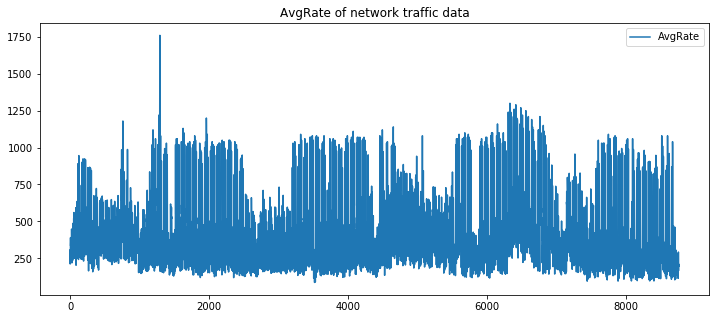

In [16]:
ax = df.plot(y='AvgRate',figsize=(12,5), title="AvgRate of network traffic data")

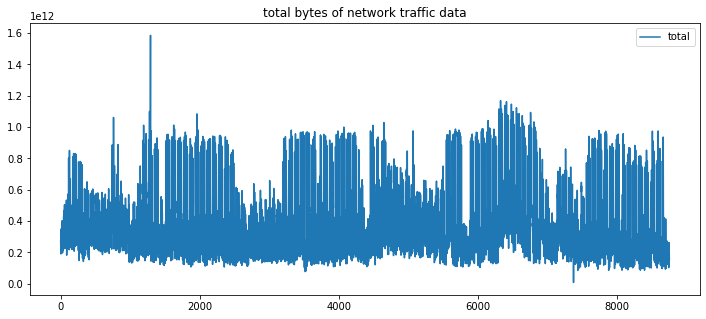

In [17]:
ax = df.plot(y='total',figsize=(12,5), title="total bytes of network traffic data")

## Time series forecasting with _AutoTS_

_AutoTS_ provides AutoML support for building end-to-end time series analysis pipelines (including automatic feature generation, model selection and hyperparameter tuning).

The general workflow using automated training contains below two steps. 
   1. create a ```AutoTSTrainer``` to train a ```TSPipeline```, save it to file to use later or elsewhere if you wish.
   2. use ```TSPipeline``` to do prediction, evaluation, and incremental fitting as well. 


First, you need to initialize RayOnSpark before using auto training (i.e. ```AutoTSTrainer```), and stop it after training finished. (Note RayOnSpark is not needed if you just use `TSPipeline` for inference, evaluation or incremental training.)


In [18]:
# init RayOnSpark in local mode
from zoo import init_spark_on_local
from zoo.ray.util.raycontext import RayContext
sc = init_spark_on_local(cores=4, spark_log_level="INFO")
ray_ctx = RayContext(sc=sc)
ray_ctx.init()

Current pyspark location is : /Users/yushan/sources/applications/spark-2.4.5-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/__init__.py
Start to getOrCreate SparkContext
Successfully got a SparkContext
Start to launch the JVM guarding process
JVM guarding process has been successfully launched
Start to launch ray on cluster
Start to launch ray on local


Then we initialize a `AutoTSTrainer`.
* `dt_col`: the column specifying datetime.
* `target_col`: target column to predict. Here, we take `AvgRate` KPI as an example.
* `horizon` : num of steps to look forward. 
* `extra_feature_col`: a list of columns which are also included in input data frame as features except target column.

In [19]:
from zoo.zouwu.autots.forecast import AutoTSTrainer

trainer = AutoTSTrainer(dt_col="datetime",
                        target_col="AvgRate",
                        horizon=1,
                        extra_features_col=None)

We can set some searching presets such as `look_back` which indicates the history time period we want to use for forecasting.

In [20]:
# look back one week values to predict the next 2h.
look_back = 84

We need to split the data frame into train, validation and test data frame before training. You can use `split_input_df` as an easy way to finish it.

In [21]:
from zoo.automl.common.util import split_input_df
train_df, val_df, test_df = split_input_df(df, ts_col="datetime", 
                                           overlap=look_back,
                                           val_split_ratio=0.1, 
                                           test_split_ratio=0.1)

Then we fit on train data and validation data. 

You can use `recipe` to specify searching method as well as other searching presets such as stop criteria .etc. The `GridRandomRecipe` here is a recipe that combines grid search with random search to find the best set of parameters. For more details, please refer to analytics-zoo document [here](https://analytics-zoo.github.io/master/#APIGuide/AutoML/recipe/).

In [33]:
from zoo.automl.regression.time_sequence_predictor import GridRandomRecipe

In [22]:
%%time
ts_pipeline = trainer.fit(train_df, val_df, 
                          recipe=GridRandomRecipe(look_back=look_back),
                          metric="mse")

2020-03-27 12:04:45,523	INFO tune.py:60 -- Tip: to resume incomplete experiments, pass resume='prompt' or resume=True to run()
2020-03-27 12:04:45,524	INFO tune.py:223 -- Starting a new experiment.
W0327 12:04:45.568445 4387286464 module_wrapper.py:139] From /Users/yushan/anaconda3/envs/automl_ut/lib/python3.6/site-packages/ray/tune/logger.py:127: The name tf.VERSION is deprecated. Please use tf.version.VERSION instead.

W0327 12:04:45.571409 4387286464 module_wrapper.py:139] From /Users/yushan/anaconda3/envs/automl_ut/lib/python3.6/site-packages/ray/tune/logger.py:132: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 0/0 GPUs (0/1.0 trainer, 0/1.0 ps)
Memory usage on this node: 11.7/17.2 GB

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 2/4 CPUs, 0/0 GPUs (0/1.0 trainer, 0/1.0 ps)
Memory usage on this node: 11.7/17.2 GB
Result logdir: /Users/yushan/ray_results/automl
Number of trials: 4 ({'RUNNING': 1, 'PENDING': 3})
PENDING trials:
 - train_func_1_dropout_2=0.36214,lstm_1_units=32,lstm_2_units=16,selected_features=['DAY(datetime)' 'WEEKDAY(datetime)' 'IS_WEEKEND(datetime)']:	PENDING
 - train_func_2_dropout_2=0.46698,lstm_1_units=16,lstm_2_units=32,selected_features=['IS_WEEKEND(datetime)' 'HOUR(datetime)' 'IS_AWAKE(datetime)'
 'MONTH(datetime)' 'WEEKDAY(datetime)' 'DAY(datetime)']:	PENDING
 - train_func_3_dropout_2=0.306,lstm_1_units=32,lstm_2_units=32,selected_features=['MONTH(datetime)' 'DAY(datetime)' 'IS_BUSY_HOURS(datetime)'
 'IS_AWAKE(datetime)']:	PENDING
RUNNING trials:
 - train_func_0_dropout_

W0327 12:05:19.233090 4387286464 module_wrapper.py:139] From /Users/yushan/anaconda3/envs/automl_ut/lib/python3.6/site-packages/ray/tune/logger.py:110: The name tf.Summary is deprecated. Please use tf.compat.v1.Summary instead.



== Status ==
Using FIFO scheduling algorithm.
Resources requested: 4/4 CPUs, 0/0 GPUs (0/1.0 trainer, 0/1.0 ps)
Memory usage on this node: 10.9/17.2 GB
Result logdir: /Users/yushan/ray_results/automl
Number of trials: 4 ({'RUNNING': 2, 'PENDING': 2})
PENDING trials:
 - train_func_2_dropout_2=0.46698,lstm_1_units=16,lstm_2_units=32,selected_features=['IS_WEEKEND(datetime)' 'HOUR(datetime)' 'IS_AWAKE(datetime)'
 'MONTH(datetime)' 'WEEKDAY(datetime)' 'DAY(datetime)']:	PENDING
 - train_func_3_dropout_2=0.306,lstm_1_units=32,lstm_2_units=32,selected_features=['MONTH(datetime)' 'DAY(datetime)' 'IS_BUSY_HOURS(datetime)'
 'IS_AWAKE(datetime)']:	PENDING
RUNNING trials:
 - train_func_0_dropout_2=0.47015,lstm_1_units=16,lstm_2_units=16,selected_features=['HOUR(datetime)' 'IS_WEEKEND(datetime)' 'IS_BUSY_HOURS(datetime)'
 'WEEKDAY(datetime)' 'DAY(datetime)' 'IS_AWAKE(datetime)']:	RUNNING, [2 CPUs, 0 GPUs], [pid=31478], 22 s, 1 iter
 - train_func_1_dropout_2=0.36214,lstm_1_units=32,lstm_2_units=16,s

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 4/4 CPUs, 0/0 GPUs (0/1.0 trainer, 0/1.0 ps)
Memory usage on this node: 11.0/17.2 GB
Result logdir: /Users/yushan/ray_results/automl
Number of trials: 4 ({'RUNNING': 2, 'PENDING': 2})
PENDING trials:
 - train_func_2_dropout_2=0.46698,lstm_1_units=16,lstm_2_units=32,selected_features=['IS_WEEKEND(datetime)' 'HOUR(datetime)' 'IS_AWAKE(datetime)'
 'MONTH(datetime)' 'WEEKDAY(datetime)' 'DAY(datetime)']:	PENDING
 - train_func_3_dropout_2=0.306,lstm_1_units=32,lstm_2_units=32,selected_features=['MONTH(datetime)' 'DAY(datetime)' 'IS_BUSY_HOURS(datetime)'
 'IS_AWAKE(datetime)']:	PENDING
RUNNING trials:
 - train_func_0_dropout_2=0.47015,lstm_1_units=16,lstm_2_units=16,selected_features=['HOUR(datetime)' 'IS_WEEKEND(datetime)' 'IS_BUSY_HOURS(datetime)'
 'WEEKDAY(datetime)' 'DAY(datetime)' 'IS_AWAKE(datetime)']:	RUNNING, [2 CPUs, 0 GPUs], [pid=31478], 119 s, 7 iter
 - train_func_1_dropout_2=0.36214,lstm_1_units=32,lstm_2_units=16,

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 4/4 CPUs, 0/0 GPUs (0/1.0 trainer, 0/1.0 ps)
Memory usage on this node: 11.1/17.2 GB
Result logdir: /Users/yushan/ray_results/automl
Number of trials: 4 ({'TERMINATED': 1, 'RUNNING': 2, 'PENDING': 1})
PENDING trials:
 - train_func_3_dropout_2=0.306,lstm_1_units=32,lstm_2_units=32,selected_features=['MONTH(datetime)' 'DAY(datetime)' 'IS_BUSY_HOURS(datetime)'
 'IS_AWAKE(datetime)']:	PENDING
RUNNING trials:
 - train_func_1_dropout_2=0.36214,lstm_1_units=32,lstm_2_units=16,selected_features=['DAY(datetime)' 'WEEKDAY(datetime)' 'IS_WEEKEND(datetime)']:	RUNNING, [2 CPUs, 0 GPUs], [pid=31469], 196 s, 9 iter
 - train_func_2_dropout_2=0.46698,lstm_1_units=16,lstm_2_units=32,selected_features=['IS_WEEKEND(datetime)' 'HOUR(datetime)' 'IS_AWAKE(datetime)'
 'MONTH(datetime)' 'WEEKDAY(datetime)' 'DAY(datetime)']:	RUNNING
TERMINATED trials:
 - train_func_0_dropout_2=0.47015,lstm_1_units=16,lstm_2_units=16,selected_features=['HOUR(date

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 4/4 CPUs, 0/0 GPUs (0/1.0 trainer, 0/1.0 ps)
Memory usage on this node: 10.5/17.2 GB
Result logdir: /Users/yushan/ray_results/automl
Number of trials: 4 ({'TERMINATED': 2, 'RUNNING': 2})
RUNNING trials:
 - train_func_2_dropout_2=0.46698,lstm_1_units=16,lstm_2_units=32,selected_features=['IS_WEEKEND(datetime)' 'HOUR(datetime)' 'IS_AWAKE(datetime)'
 'MONTH(datetime)' 'WEEKDAY(datetime)' 'DAY(datetime)']:	RUNNING, [2 CPUs, 0 GPUs], [pid=31477], 70 s, 3 iter
 - train_func_3_dropout_2=0.306,lstm_1_units=32,lstm_2_units=32,selected_features=['MONTH(datetime)' 'DAY(datetime)' 'IS_BUSY_HOURS(datetime)'
 'IS_AWAKE(datetime)']:	RUNNING, [2 CPUs, 0 GPUs], [pid=31470], 44 s, 1 iter
TERMINATED trials:
 - train_func_0_dropout_2=0.47015,lstm_1_units=16,lstm_2_units=16,selected_features=['HOUR(datetime)' 'IS_WEEKEND(datetime)' 'IS_BUSY_HOURS(datetime)'
 'WEEKDAY(datetime)' 'DAY(datetime)' 'IS_AWAKE(datetime)']:	TERMINATED, [2 CPUs, 0 G

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 4/4 CPUs, 0/0 GPUs (0/1.0 trainer, 0/1.0 ps)
Memory usage on this node: 10.7/17.2 GB
Result logdir: /Users/yushan/ray_results/automl
Number of trials: 4 ({'TERMINATED': 2, 'RUNNING': 2})
RUNNING trials:
 - train_func_2_dropout_2=0.46698,lstm_1_units=16,lstm_2_units=32,selected_features=['IS_WEEKEND(datetime)' 'HOUR(datetime)' 'IS_AWAKE(datetime)'
 'MONTH(datetime)' 'WEEKDAY(datetime)' 'DAY(datetime)']:	RUNNING, [2 CPUs, 0 GPUs], [pid=31477], 189 s, 8 iter
 - train_func_3_dropout_2=0.306,lstm_1_units=32,lstm_2_units=32,selected_features=['MONTH(datetime)' 'DAY(datetime)' 'IS_BUSY_HOURS(datetime)'
 'IS_AWAKE(datetime)']:	RUNNING, [2 CPUs, 0 GPUs], [pid=31470], 159 s, 5 iter
TERMINATED trials:
 - train_func_0_dropout_2=0.47015,lstm_1_units=16,lstm_2_units=16,selected_features=['HOUR(datetime)' 'IS_WEEKEND(datetime)' 'IS_BUSY_HOURS(datetime)'
 'WEEKDAY(datetime)' 'DAY(datetime)' 'IS_AWAKE(datetime)']:	TERMINATED, [2 CPUs, 0

2020-03-27 12:13:15,935	INFO ray_trial_executor.py:180 -- Destroying actor for trial train_func_3_dropout_2=0.306,lstm_1_units=32,lstm_2_units=32,selected_features=['MONTH(datetime)' 'DAY(datetime)' 'IS_BUSY_HOURS(datetime)'
 'IS_AWAKE(datetime)']. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
W0327 12:13:16.006530 4387286464 deprecation.py:506] From /Users/yushan/anaconda3/envs/automl_ut/lib/python3.6/site-packages/tensorflow_core/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0327 12:13:16.011751 4387286464 deprecation.py:506] From /Users/yushan/anaconda3/envs/automl_ut/lib/python3.6/site-packages/tensorflow_core/python/ops/init_ops.py:97: calling Orthogonal.__init__ (from tensorflow.pytho

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 0/0 GPUs (0/1.0 trainer, 0/1.0 ps)
Memory usage on this node: 8.8/17.2 GB
Result logdir: /Users/yushan/ray_results/automl
Number of trials: 4 ({'TERMINATED': 4})
TERMINATED trials:
 - train_func_0_dropout_2=0.47015,lstm_1_units=16,lstm_2_units=16,selected_features=['HOUR(datetime)' 'IS_WEEKEND(datetime)' 'IS_BUSY_HOURS(datetime)'
 'WEEKDAY(datetime)' 'DAY(datetime)' 'IS_AWAKE(datetime)']:	TERMINATED, [2 CPUs, 0 GPUs], [pid=31478], 172 s, 10 iter
 - train_func_1_dropout_2=0.36214,lstm_1_units=32,lstm_2_units=16,selected_features=['DAY(datetime)' 'WEEKDAY(datetime)' 'IS_WEEKEND(datetime)']:	TERMINATED, [2 CPUs, 0 GPUs], [pid=31469], 218 s, 10 iter
 - train_func_2_dropout_2=0.46698,lstm_1_units=16,lstm_2_units=32,selected_features=['IS_WEEKEND(datetime)' 'HOUR(datetime)' 'IS_AWAKE(datetime)'
 'MONTH(datetime)' 'WEEKDAY(datetime)' 'DAY(datetime)']:	TERMINATED, [2 CPUs, 0 GPUs], [pid=31477], 237 s, 10 iter
 - train

W0327 12:13:16.803703 4387286464 backend.py:548] OMP_NUM_THREADS is no longer used by the default Keras config. To configure the number of threads, use tf.config.threading APIs.
W0327 12:13:17.411523 4387286464 deprecation.py:323] From /Users/yushan/anaconda3/envs/automl_ut/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


CPU times: user 14.6 s, sys: 4.26 s, total: 18.9 s
Wall time: 8min 35s


We get a `TSPipeline` after training. You can use it to do prediction, evaluation or incremental fitting.

In [23]:
pred_df = ts_pipeline.predict(test_df)

plot actual and prediction values for `AvgRate` KPI

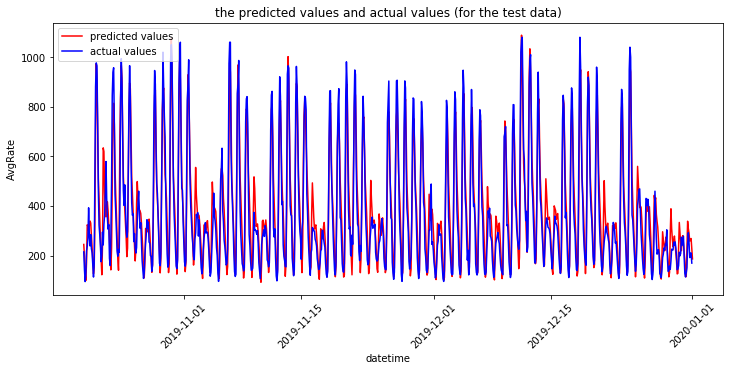

In [24]:
# plot the predicted values and actual values
plot_result(test_df, pred_df, 
            dt_col="datetime", value_col="AvgRate", 
            look_back=look_back)

Calculate mean square error and the symetric mean absolute percentage error.

In [25]:
mse, smape = ts_pipeline.evaluate(test_df, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

Evaluate: the mean square error is 6772.399576209641
Evaluate: the smape value is 9.739794561585315


You can save the pipeline to file and reload it to do incremental fitting or others.

In [26]:
# save pipeline file
my_ppl_file_path = ts_pipeline.save("/tmp/saved_pipeline/my.ppl")

Pipeline is saved in /tmp/saved_pipeline/my.ppl


You can stop RayOnSpark after auto training.

In [28]:
# stop
ray_ctx.stop()
sc.stop()

Stopping pgids: [31460, 31472]
Stopping by pgid 31460
Stopping by pgid 31472


Next, we demonstrate how to do incremental fitting with your saved pipeline file.

First load saved pipeline file.

In [29]:
# load file
from zoo.zouwu.autots.forecast import TSPipeline
loaded_ppl = TSPipeline.load(my_ppl_file_path)

Restore pipeline from /tmp/saved_pipeline/my.ppl


Then do incremental fitting with `TSPipeline.fit()`.We use validation data frame as additional data for demonstration. You can use your new data frame.


In [30]:
# we use validation data frame as additional data for demonstration. 
loaded_ppl.fit(val_df, epochs=5)

Train on 876 samples
Epoch 1/5
876/876 [==============================] - 1s 1ms/sample - loss: 0.1298 - mean_squared_error: 0.1298
Epoch 2/5
876/876 [==============================] - 0s 450us/sample - loss: 0.1202 - mean_squared_error: 0.1202
Epoch 3/5
876/876 [==============================] - 0s 400us/sample - loss: 0.1234 - mean_squared_error: 0.1234
Epoch 4/5
876/876 [==============================] - 0s 412us/sample - loss: 0.1185 - mean_squared_error: 0.1185
Epoch 5/5
876/876 [==============================] - 0s 431us/sample - loss: 0.1102 - mean_squared_error: 0.1102
Fit done!


predict and plot the result after incremental fitting.

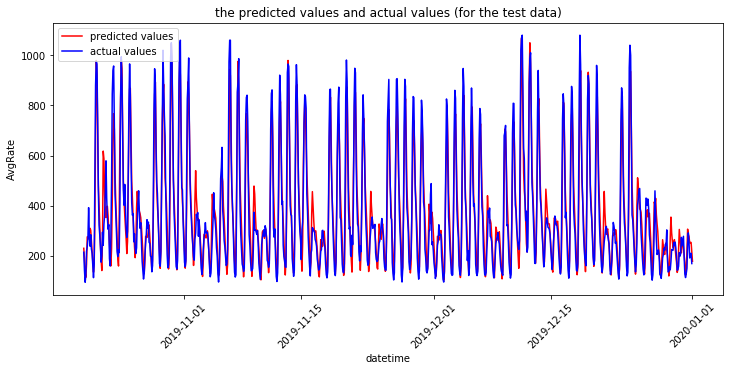

In [31]:
# predict results of test_df
new_pred_df = loaded_ppl.predict(test_df)
plot_result(test_df, new_pred_df, look_back=look_back)

Calculate mean square error and the symetric mean absolute percentage error.

In [32]:
# evaluate test_df
mse, smape = loaded_ppl.evaluate(test_df, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

Evaluate: the mean square error is 6194.117777242716
Evaluate: the smape value is 8.414774827438276
